# Chapter 8 Lab 4

## Goal
We are going to learn how to tune the hyperparameters of a RandomForestClassifier using GridSearchCV. GridSearchCV stores results in a table called 'cv_results_'.

We will again consider the task of predicting players’ SkillLevel, which takes integer value between 0 and 3, with 0 being novice level and 3 expert.

For illustrative purposes, consider the Naive Bayes model from Chapter 7, lab 3 (note that you can use any other model you have trained so far for this purpose).

## Brief Refresher

Model selection refers to the process of tuning hyperparameters, i.e. parameters that need to be set before training a model. GridSearchCV is a popular approach in doing so. It splits the training data in equal parts (the 'CV' part) and runs the different possible permutations of the hyperparameters against the data, recording the results. For the RandomForestClassifier, the main metric would be Accuracy. For reasons discussed in Step 3, you'll see how this can quickly get out of hand.

## Preparation

Load the required packages below.

In [2]:
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score, classification_report, precision_recall_fscore_support, make_scorer, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

## Step 1: Data Pre-processing and Model Building

We've done these steps enough to condense them together in order to speed the process of getting to metric evaluation.

In [3]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
dota_df1.drop(['PlayerID'], axis=1, inplace=True)

dota_df1 = dota_df1.rename(columns=lambda x: x.strip())

dota_df1['TotalTime'] = pd.to_numeric(dota_df1['TotalTime'], errors='coerce')

dota_df1.loc[dota_df1['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

dota_df1['SkillLevel'] = pd.Series(dota_df1['SkillLevel'].astype('category'))

dota_df1['SkillLevel'] = dota_df1['SkillLevel'].cat.rename_categories({'0':'N', '1':'B', '2':'I', '3':'A'})

dota_df1.drop([517], inplace=True)

dota_df1.describe()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,8.670000e+02
mean,92.343714,50.369089,1.650519,0.711649,1014.840856,608.660900,0.131799,545.094579,951.763552,7636.831603,677.627451,1259.800461,70.786621,29.740484,2.283400e+05
std,205.574415,115.795471,3.239320,1.808982,119.954984,1502.754591,0.065829,1204.140278,2230.809200,19801.024410,2029.775852,2969.501221,175.869846,74.661056,4.751062e+05
min,1.000000,0.000000,0.000000,0.000000,626.837000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.349000e+03
25%,3.000000,1.000000,0.000000,0.000000,961.886000,11.000000,0.090000,17.500000,18.000000,160.500000,12.000000,16.000000,1.000000,0.000000,6.270000e+03
50%,15.000000,7.000000,0.000000,0.000000,996.646000,74.000000,0.130000,93.000000,125.000000,983.000000,76.000000,146.000000,7.000000,3.000000,3.516000e+04
75%,90.000000,47.500000,2.000000,1.000000,1046.975000,514.500000,0.170000,554.000000,865.000000,6732.000000,541.500000,1130.500000,62.000000,26.000000,2.234100e+05
max,3156.000000,1764.000000,40.000000,18.000000,2010.240000,23742.000000,0.420000,16988.000000,34390.000000,372360.000000,43910.000000,42900.000000,2601.000000,1141.000000,4.294920e+06


Next, we'll split the data first into predictors and target and then into training and test

In [4]:
y = dota_df1['SkillLevel']
X = dota_df1.drop(['SkillLevel'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

## Step 2: Find out what parameters are tunable.

Since we don't need to standardize for the RandomForest, we can move on to our model.

First, we want to know what parameters are tunable. Below, we instantiate our model object and pull a list, along with default values.

Below, we did set three parameters initially to ensure we align with R defaults. These are reflected in the output.


In [5]:
rtc = RandomForestClassifier(n_estimators=500, bootstrap=True, oob_score=True)
rtc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Step 3: Set up a grid of parameter configurations

Next, well pick three of these and set up a parameter grid to explore.

In [58]:
min_samps = [1, 2, 3, 5, 7, 10]
mtry = [2, 4, 6, 10, 15]
split_rule = ['gini', 'entropy']
params = {'max_features' : mtry, 'min_samples_leaf' : min_samps, 'criterion' : split_rule}

As you see, we have 3 hyperparameters to tune - 'max_features', 'min_samples_leaf' and 'criterion'. We've chosen 5, 6, and 2 possible values for each respectively.

This means the GridSearchCV will at least run 60 different models (5*6*2). The computational resources needed can explode suddenly here. Simply add 1 more 'criterion' to make it 3 possible values and you will need to run 90 different models!

## Step 4: Set up cross validation

In [59]:
#Setup and configure settings for Repeated k-Fold CV (k-folds=10, repeats=3)
rcv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=101)

## Step 5: Train the model with cross validation and GridSearchCV

Sklearn does not implement 'extratrees' as a split rule (impurity measure). It uses 'gini', 'entropy' or 'log_loss'. So, to compare, we will implement RandomForestClassifier and ExtraTreesClassifier and compare.

As an extra step, we need to define a new scorer for GridSearchCV

In [8]:
#define a new scorer
def kappa_scorer(est, X, y):
    y_pred = est.predict(X)
    kappa = cohen_kappa_score(y, y_pred)
    return kappa

In [ ]:
#define scoring
scoring = {'Accuracy':'accuracy', 'Kappa':make_scorer(cohen_kappa_score)}

#create model, perform Repeated CV and evaluate model
scores = GridSearchCV(rtc, params, scoring=scoring, cv=rcv, refit='Accuracy', n_jobs=-1)
scores.fit(X_train, y_train)

In [10]:
cv_df = pd.DataFrame(scores.cv_results_)
cv_res_df = pd.DataFrame(cv_df[[ 'param_max_features', 'param_criterion', 'param_min_samples_leaf', 'mean_test_Accuracy', 'mean_test_Kappa']])
cv_res_df.rename(columns = {'param_max_features' : 'Mtry', 'param_criterion' : 'Splitrule', 'param_min_samples_leaf' : 'min.node.size',  'mean_test_Accuracy' : 'Accuracy', 'mean_test_Kappa' : 'Kappa'}, inplace=True)
cv_res_df.sort_values(by=['Mtry', 'Splitrule'])

,Mtry,Splitrule,min.node.size,Accuracy,Kappa
30,2,entropy,1,0.911282,0.826619
31,2,entropy,2,0.911282,0.826572
32,2,entropy,3,0.907179,0.818256
33,2,entropy,5,0.907692,0.818692
34,2,entropy,7,0.907179,0.817779
35,2,entropy,10,0.908718,0.820787
0,2,gini,1,0.910769,0.825428
1,2,gini,2,0.909231,0.822177
2,2,gini,3,0.907692,0.819230
3,2,gini,5,0.907692,0.818706


In [11]:
scores.best_params_

{'criterion': 'entropy', 'max_features': 10, 'min_samples_leaf': 1}

In [12]:
xtc = RandomForestClassifier(n_estimators=500, bootstrap=True, oob_score=True)

scores_x = GridSearchCV(xtc, params, scoring=scoring, cv=rcv, refit='Accuracy', n_jobs=-1)
scores_x.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=101),
             estimator=RandomForestClassifier(n_estimators=500, oob_score=True),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [2, 4, 6, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 5, 7, 10]},
             refit='Accuracy',
             scoring={'Accuracy': 'accuracy',
                      'Kappa': make_scorer(cohen_kappa_score)})

In [24]:
cvx_df = pd.DataFrame(scores_x.cv_results_)
cvx_res_df = pd.DataFrame(cvx_df[[ 'param_max_features', 'param_criterion', 'param_min_samples_leaf', 'mean_test_Accuracy', 'mean_test_Kappa']])
cvx_res_df.rename(columns = {'param_max_features' : 'Mtry', 'param_criterion' : 'Splitrule', 'param_min_samples_leaf' : 'min.node.size',  'mean_test_Accuracy' : 'Accuracy', 'mean_test_Kappa' : 'Kappa'}, inplace=True)
cvx_res_df.sort_values(by=['Mtry', 'Splitrule'])

,Mtry,Splitrule,min.node.size,Accuracy,Kappa
30,2,entropy,1,0.910769,0.825562
31,2,entropy,2,0.910256,0.824550
32,2,entropy,3,0.908718,0.821293
33,2,entropy,5,0.906667,0.816716
34,2,entropy,7,0.907179,0.817707
35,2,entropy,10,0.906154,0.815588
0,2,gini,1,0.911282,0.826103
1,2,gini,2,0.911795,0.827341
2,2,gini,3,0.909231,0.822139
3,2,gini,5,0.908718,0.820777


In [14]:
scores_x.best_params_

{'criterion': 'entropy', 'max_features': 10, 'min_samples_leaf': 1}

In both cases, the best set of parameters are the same! Let's see if that holds when we plot the results as well.

## Step 6: Plot the Accuracy of the Models (Optional)

In [100]:
def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_Accuracy'):
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.lineplot(x=col_x, y=metric, hue=col_z, data=cv_results, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel('min.node.size')
    ax.set_ylabel('Accuracy')
    ax.legend(title=param_z)
    return fig

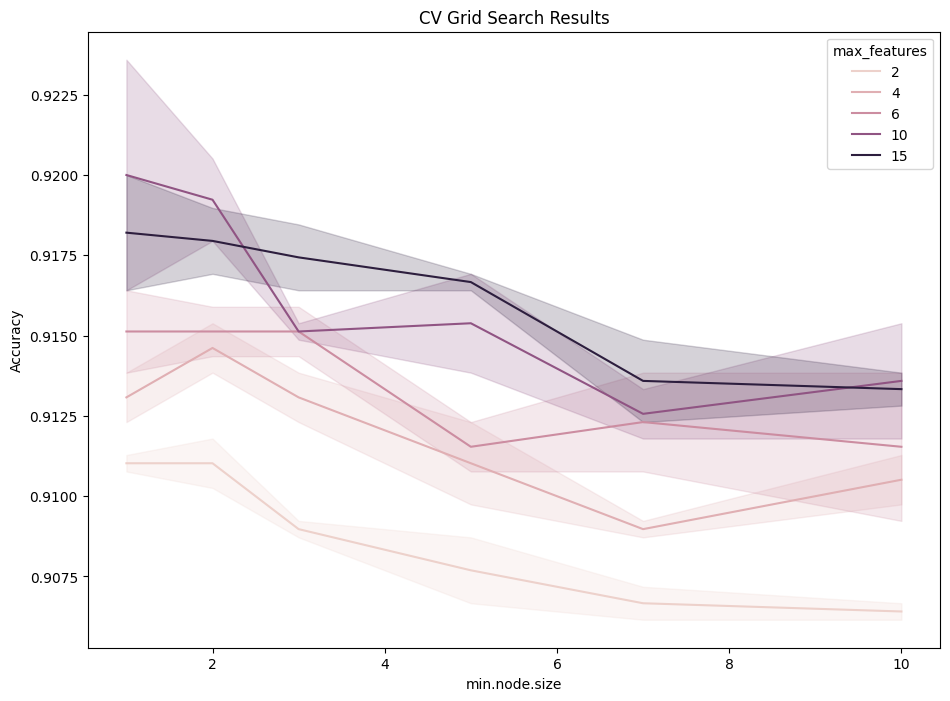

In [101]:
fig = plot_cv_results(scores_x.cv_results_, 'min_samples_leaf', 'max_features')

## Step 7: Apply the model to the test set.

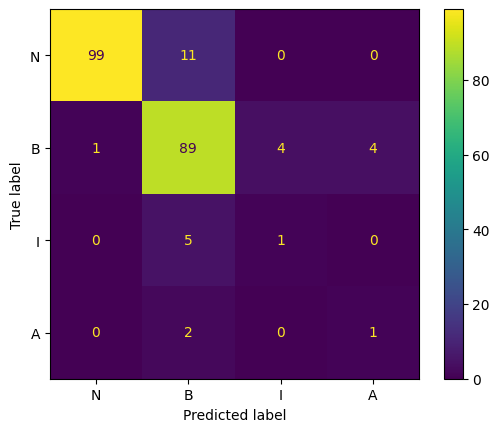

In [35]:
final_model = scores_x.best_estimator_
rfc_pred = final_model.predict(X_test)
labels = ['N', 'B', 'I', 'A']
ConfusionMatrixDisplay.from_predictions(y_test, rfc_pred, labels=labels)
plt.show()

In [36]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, rfc_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.20      0.33      0.25         3
     class 1       0.83      0.91      0.87        98
     class 2       0.20      0.17      0.18         6
     class 3       0.99      0.90      0.94       110

    accuracy                           0.88       217
   macro avg       0.56      0.58      0.56       217
weighted avg       0.89      0.88      0.88       217



The accuracy is only slightly less than when we performed almost the same process in Chapter 7, Lab 9. There we simply used GridSearchCV to mimic the process done in R.

More importantly, instead of comparing two different instances of using GridSearchCV, we should compare the results of accuracy using the training data and test data. In this case, we would want to see comparable or slightly worse performance on the test data.

## Conclusion

In this lab, we showed you how to use cross validation and GridSearchCV to tune some of the RandomForest parameters in sklearn.